In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/COMP4471_project/
!pip install pytorch-ignite

Mounted at /content/drive/
/content/drive/MyDrive/COMP4471_project
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 30.9 MB/s 


In [2]:
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import random
import os
import glob
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from model import UNET, DoubleConv, ResidualBlock, GeneratorResNet, Discriminator
import itertools
from tqdm.notebook import tqdm
import warnings
import operator
from ignite.metrics import FID
from ignite.engine import *

### General settings

In [3]:
#dataset_name = 'gan-getting-started'
root = '/content/drive/MyDrive/COMP4471_project/'

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0
n_epochs = 50 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

### Customize dataset

In [4]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train', size=500):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'datasets/art_data/art')+'/*.*')[:3000])
            self.files_B = sorted(glob.glob(os.path.join(root+'datasets/matting_data/face')+'/*.*')[:3000])

            rand_A = random.sample(range(len(self.files_A)), size)
            rand_B = random.sample(range(len(self.files_B)), size)

        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'datasets/art_data/art')+'/*.*')[3000:])
            self.files_B = sorted(glob.glob(os.path.join(root+'datasets/matting_data/face')+'/*.*')[3000:])

            rand_A = random.sample(range(len(self.files_A)), size//5)
            rand_B = random.sample(range(len(self.files_B)), size//5)

        self.files_A = operator.itemgetter(*rand_A)(self.files_A)
        self.files_B = operator.itemgetter(*rand_B)(self.files_B)

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

### GPU setting

In [5]:
cuda = torch.cuda.is_available()
# set tensor type to cuda tensor if gpu available
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

### Init data

In [6]:
transforms_ = [
    transforms.Resize(int(img_height), Image.BICUBIC),
    transforms.CenterCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
# train data
train_data = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=2
)

# validation data
val_data = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=2
)

## Training utils

### Init models

In [7]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)


In [ ]:
# Settings to resume training
# Modify these two lines to continue training!
cont_train = True
last_version = 89

if cont_train:
    G_AB = GeneratorResNet(input_shape, n_residual_blocks)
    G_BA = GeneratorResNet(input_shape, n_residual_blocks)
    D_A = Discriminator(input_shape)
    D_B = Discriminator(input_shape)
    G_AB = torch.load('models/Masked_CycleGAN/generatorA2B_{}.pt'.format(last_version)).cuda()
    G_BA = torch.load('models/Masked_CycleGAN/generatorB2A_{}.pt'.format(last_version)).cuda()
    D_A = torch.load('models/Masked_CycleGAN/discriminatorA_{}.pt'.format(last_version)).cuda()
    D_B = torch.load('models/Masked_CycleGAN/discriminatorB_{}.pt'.format(last_version)).cuda()

else:

    G_AB = GeneratorResNet(input_shape, n_residual_blocks).cuda().apply(weights_init_normal)
    G_BA = GeneratorResNet(input_shape, n_residual_blocks).cuda().apply(weights_init_normal)
    D_A = Discriminator(input_shape).cuda().apply(weights_init_normal)
    D_B = Discriminator(input_shape).cuda().apply(weights_init_normal)

### Init optimizers

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [ ]:
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1,b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1,b2))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

### Init loss functions

In [ ]:
criterion_GAN = torch.nn.MSELoss().cuda()
criterion_cycle = torch.nn.L1Loss().cuda()
criterion_identity = torch.nn.L1Loss().cuda()

### Define portrait mask using Unet


In [ ]:
# Transform a full portrait to a bg-removed one
def mask(orig, model_path='/content/drive/MyDrive/COMP4471_project/models/Unet/model_full_unetv14.pth', mode='soft'):

    shape = orig.shape
    my_unet = UNET(3,1)
    my_unet = torch.load(model_path)
    #print(orig.shape)
    with torch.no_grad():
        
        preds = my_unet(orig).cpu()
        # preds[preds < 0.5] = 0
        # preds[preds >= 0.5] = 1
        
        #preds = np.squeeze(preds)
        #orig = orig.reshape((3, img_height, img_width)).cpu()
        orig = orig.cpu()
        
       
        # masked = np.where(preds>=0.5, orig, preds)
        # return torch.from_numpy(masked).cuda()
        if mode == 'soft':
            masked = (orig * preds)
            return masked.cuda()
        if mode == 'hard':
            masked = np.where(preds>=0.5, orig, preds)
            return torch.from_numpy(masked).cuda()

        

### Sample generated images

In [10]:
def show_image(image, title=None, cmap=None):
    
    # transpose image
    image = np.transpose(image.cpu().numpy(), [1,2,0])

    # if gray scale, reshape
    if image.shape[2] == 1:
        image = image.reshape((image.shape[0], image.shape[1]))

    plt.imshow(image, cmap=cmap)
    if title is not None : plt.title(title)
    plt.axis('off')

def sample_images(epoch=0, i=0):
    """show a generated sample from the test set"""
    
    imgs = next(iter(val_data))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : art
    fake_B = G_AB(real_A).detach()
    masked_fake_B = mask(fake_B, mode='hard').detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    masked_fake_A = mask(fake_A, mode='hard').detach()
    
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    masked_fake_B = make_grid(masked_fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    masked_fake_A = make_grid(masked_fake_A, nrow=5, normalize=True)

    plt.figure(figsize=(10, 12))

    plt.subplot(6, 1, 1)
    show_image(real_A, title="Real A")

    plt.subplot(6, 1, 2)
    show_image(fake_B, title="Fake B")

    plt.subplot(6, 1, 3)
    show_image(masked_fake_B, title="Masked fake B")

    plt.subplot(6, 1, 4)
    show_image(real_B, title="Real B")

    plt.subplot(6, 1, 5)
    show_image(fake_A, title="Fake A")

    plt.subplot(6, 1, 6)
    show_image(masked_fake_A, title="Masked fake A")

    plt.tight_layout()

    plt.savefig(str(root + 'results/masked/' + 'masked%02d%04d.png' % (epoch, i)))
    plt.show()
    

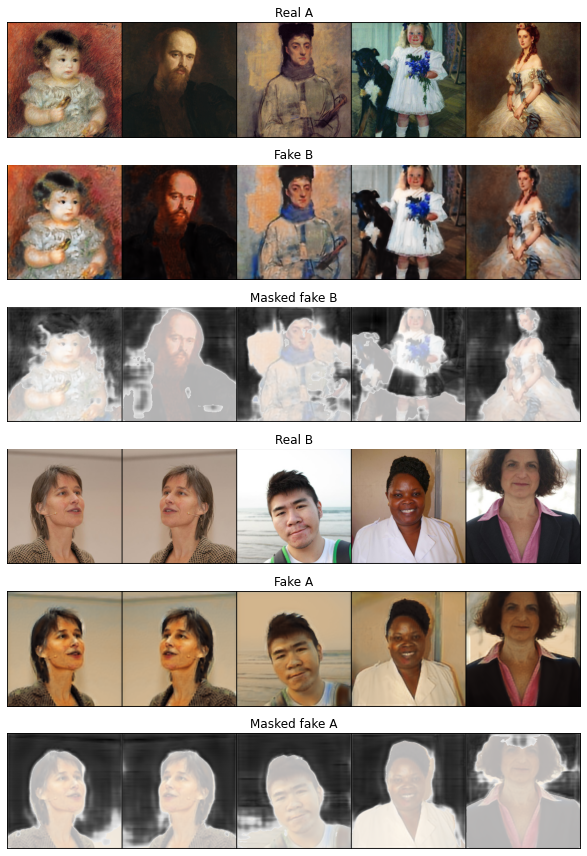

In [ ]:
sample_images()

### Define image pool

In [ ]:
class ImagePool():
    def __init__(self, size):
        self.pool_size = size
        self.images = []
        self.num_images = 0

    def update(self, image):
        # Input image is a tensor of shape (1, 3, H, W)
        selected_image = None
        if self.num_images < self.pool_size:
            self.num_images += 1
            self.images.append(image)
            selected_image = image
        
        # Pool is full
        else:
            p = random.uniform(0, 1)
            if p < 0.5:
                random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                selected_image = self.images[random_id].clone()
                self.images[random_id] = image
            else:
                selected_image = image

        return selected_image

## Training

### Train function

In [ ]:
def train(n_epochs=10, use_pool=True, data=train_data, mask_prob=0.5, mask_mode='soft'):
    # Initialize 2 image pools for generated fake images
    if use_pool:
        fake_B_pool = ImagePool(3)
        fake_A_pool = ImagePool(3)

    # Training loop
    for epoch in range(last_version+1, n_epochs+last_version+1):
        for i, batch in enumerate(tqdm(data)):
                
            # Set model input
            real_A = batch['A'].type(Tensor)
            real_B = batch['B'].type(Tensor)
                
            # Adversarial ground truths
            valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
            fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
                
            # -----------------
            # Train Generators
            # -----------------
            G_AB.train() # train mode
            G_BA.train() # train mode
                
            optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
                
            # Identity Loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
            loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                                # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
            loss_identity = (loss_id_A + loss_id_B)/2
                
            # GAN Loss
            fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
            fake_A = G_BA(real_B)
        
            if use_pool:
                # Query into the image pool
                fake_B = fake_B_pool.update(fake_B).detach()
                fake_A = fake_A_pool.update(fake_A).detach()

            # Add in unet for bg removal
            # Discriminator examines only the human body part to distinguish real or fake
            rand = random.random()
            if rand < mask_prob:
                loss_GAN_AB = criterion_GAN(D_B(mask(fake_B, mode=mask_mode)), valid) # tricking the 'fake-B' into 'real-B'
                loss_GAN_BA = criterion_GAN(D_A(mask(fake_A, mode=mask_mode)), valid) # tricking the 'fake-A' into 'real-A'
            else:
                loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
                loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
                
            loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
                
            # Cycle Loss
            recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
            loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)
                
            loss_cycle = (loss_cycle_A + loss_cycle_B)/2
                
            # ------> Total Loss
            loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
                
            loss_G.backward()
            optimizer_G.step()
                
            # -----------------
            # Train Discriminator A
            # -----------------
            optimizer_D_A.zero_grad()
        
            loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
            loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
                
            loss_D_A = (loss_real + loss_fake)/2
                
            loss_D_A.backward()
            optimizer_D_A.step()

            # -----------------
            # Train Discriminator B
            # -----------------
            optimizer_D_B.zero_grad()
        
            loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
            loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
                
            loss_D_B = (loss_real + loss_fake)/2
                
            loss_D_B.backward()
            optimizer_D_B.step()
                
            # ------> Total Loss
            loss_D = (loss_D_A + loss_D_B)/2

        
            # -----------------
            # Show Progress
            # -----------------
            if (i+1) % 100 == 0:
                if rand >= mask_prob:
                    print("Using masked adversarial loss.")
                sample_images(epoch+1, i+1)
                print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                        %(epoch+1,n_epochs+last_version+1,      # [Epoch -]
                        i+1,len(data),                          # [Batch -]
                        loss_D.item(),                          # [D loss -]
                        loss_G.item(),                          # [G loss -]
                        loss_GAN.item(),                        # [adv -]
                        loss_cycle.item(),                      # [cycle -]
                        loss_identity.item(),                   # [identity -]
                        ))
        print("Saving models for epoch", epoch)
        torch.save(G_AB, 'models/Masked_CycleGAN/generatorA2B_{}.pt'.format(epoch))
        torch.save(G_BA, 'models/Masked_CycleGAN/generatorB2A_{}.pt'.format(epoch))
        torch.save(D_A, 'models/Masked_CycleGAN/discriminatorA_{}.pt'.format(epoch))
        torch.save(D_B, 'models/Masked_CycleGAN/discriminatorB_{}.pt'.format(epoch))

In [ ]:
# work on dev data to make sure everything running okay
dev_data = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, size=10),
    batch_size=1,
    shuffle=True,
    num_workers=2
)
train(n_epochs=3, use_pool=True, data=dev_data)

  0%|          | 0/10 [00:00<?, ?it/s]

Saving models for epoch 0


  0%|          | 0/10 [00:00<?, ?it/s]

Saving models for epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]

Saving models for epoch 2


### Training process

In [ ]:
# 1st training process (start: epoch 0, end: epoch 4, duration: 5 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=5, use_pool=False, data=train_data, mask_prob=0.1)

In [ ]:
# 2nd training process (start: epoch 5, end: epoch 9, duration: 5 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=5, use_pool=True, data=train_data, mask_prob=0.2)

In [ ]:
# 3rd training process (start: epoch 10, end: epoch 19, duration: 10 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=10, use_pool=True, data=train_data, mask_prob=0.2)

In [ ]:
# 4th training process (start: epoch 20, end: epoch 29, duration: 10 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=10, use_pool=True, data=train_data, mask_prob=0.5)

In [ ]:
# 5th training process (start: epoch 30, end: epoch 36, duration: 7 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=10, use_pool=True, data=train_data, mask_prob=0.7)

In [ ]:
# 6th training process (start: epoch 37, end: epoch 39, duration: 3 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=3, use_pool=True, data=train_data, mask_prob=0.7)

In [ ]:
# 7th training process (start: epoch 40, end: epoch 49, duration: 10 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=10, use_pool=True, data=train_data, mask_prob=0.9)

In [ ]:
# 8th training process (start: epoch 50, end: epoch 69, duration: 20 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=20, use_pool=True, data=train_data, mask_prob=0.9)

In [ ]:
# 9th training process (start: epoch 70, end: epoch 75, duration: 6 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=6, use_pool=True, data=train_data, mask_prob=0.9)

In [ ]:
# 10th training process (start: epoch 76, end: epoch 79, duration: 4 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=4, use_pool=True, data=train_data, mask_prob=1.0)

In [ ]:
# 11st training process (start: epoch 80, end: epoch 89, duration: 10 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=10, use_pool=True, data=train_data, mask_prob=1.0)

In [ ]:
# 12nd training process (start: epoch 90, end: epoch 99, duration: 10 epochs)
# About 7 min/epoch, use time wisely!
train(n_epochs=10, use_pool=True, data=train_data, mask_prob=1.0)

Output hidden; open in https://colab.research.google.com to view.

## Testing

### Test on individual images

In [8]:
def test_individual(version, img_path):

    G_AB_test = GeneratorResNet(input_shape, n_residual_blocks)
    G_AB_test = torch.load('models/Masked_CycleGAN/generatorA2B_{}.pt'.format(version)).cuda()
    G_AB_test.eval()

    real_A = to_rgb(Image.open(root + 'datasets/art_data/art/' + img_path))
    real_A = transforms.Compose(transforms_)(real_A).cuda()
    c, h, w = real_A.shape
    real_A = make_grid(real_A, nrow=1, normalize=True)

    fake_B = G_AB_test(real_A.reshape((1, c, h, w))).detach()
    fake_B = fake_B.reshape((c, h, w))
    fake_B = make_grid(fake_B, nrow=1, normalize=True)
    
    plt.figure(figsize=(10, 12))

    plt.subplot(1, 2, 1)
    show_image(real_A, title="Original")

    plt.subplot(1, 2, 2)
    show_image(fake_B, title="Generated")

def output_test(version, img_path, model):

    G_AB_test = GeneratorResNet(input_shape, n_residual_blocks)
    if model == 'mask':
        G_AB_test = torch.load('models/Masked_CycleGAN/generatorA2B_{}.pt'.format(version)).cuda()
    if model == 'vanilla':
        G_AB_test = torch.load('models/Vanilla_CycleGAN/generatorA2B_{}.pt'.format(version)).cuda()
    
    G_AB_test.eval()

    real_A = to_rgb(Image.open(root + 'datasets/art_data/art/' + img_path))
    real_A = transforms.Compose(transforms_)(real_A).cuda()
    c, h, w = real_A.shape
    real_A = make_grid(real_A, nrow=1, normalize=True)

    fake_B = G_AB_test(real_A.reshape((1, c, h, w))).detach()
    fake_B = fake_B.reshape((c, h, w))
    fake_B = make_grid(fake_B, nrow=1, normalize=True)

    show_image(fake_B)

In [27]:
def output_real(img_path):
    real_A = to_rgb(Image.open(root + 'datasets/art_data/art/' + img_path))
    real_A = transforms.Compose(transforms_)(real_A).cuda()
    real_A = make_grid(real_A, nrow=1, normalize=True)
    show_image(real_A)

In [ ]:
def view_progress(start, end, img_path):
    
    fig_height = 10 * ((end-start)//20)
    plt.figure(figsize=(10,fig_height))
    total_img = end // 10 + 1
    for i in range(start, end, 10):
        G_AB_test_1 = GeneratorResNet(input_shape, n_residual_blocks)
        G_AB_test_1 = torch.load('models/Masked_CycleGAN/generatorA2B_{}.pt'.format(i)).cuda()
        G_AB_test_1.eval()

        G_AB_test_2 = GeneratorResNet(input_shape, n_residual_blocks)
        G_AB_test_2 = torch.load('models/Masked_CycleGAN/generatorA2B_{}.pt'.format(i+5)).cuda()
        G_AB_test_2.eval()

        real_A = to_rgb(Image.open(root + 'datasets/art_data/art/' + img_path))
        real_A = transforms.Compose(transforms_)(real_A).cuda()
        c, h, w = real_A.shape
        # real_A = make_grid(real_A, nrow=1, normalize=True)

        fake_B_1 = G_AB_test_1(real_A.reshape((1, c, h, w))).detach()
        fake_B_1 = fake_B_1.reshape((c, h, w))
        fake_B_1 = make_grid(fake_B_1, nrow=1, normalize=True)

        fake_B_2 = G_AB_test_2(real_A.reshape((1, c, h, w))).detach()
        fake_B_2 = fake_B_2.reshape((c, h, w))
        fake_B_2 = make_grid(fake_B_2, nrow=1, normalize=True)
        
        
        plt.subplot(total_img, 2, 2*(i/10)+1)
        show_image(fake_B_1, title="Generated (version "+str(i)+")")

        plt.subplot(total_img, 2, 2*(i/10)+2)
        show_image(fake_B_2, title="Generated (version "+str(i+5)+")")

    plt.tight_layout()
    plt.show()

### Frechet Inception Distance

In [36]:
test_data = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

In [43]:
def eval_step(engine, batch):
    return batch

def compute_fid(model_type, model_ver, raw=False):

    G_AB = GeneratorResNet(input_shape, n_residual_blocks)
    if model_type == 'vanilla':
        G_AB = torch.load('models/Vanilla_CycleGAN/generatorA2B_{}.pt'.format(model_ver)).cuda()
    if model_type == 'masked':
        G_AB = torch.load('models/Masked_CycleGAN/generatorA2B_{}.pt'.format(model_ver)).cuda()

    G_AB.eval()
    running_fid = 0
    for i, imgs in enumerate(iter(test_data)):
        portraits = imgs['A'].type(Tensor)
        photo = imgs['B'].type(Tensor)
        if raw:
            generated_portraits = portraits.detach()
        else:
            generated_portraits = G_AB(portraits).detach()

        # shape (N, channel, H, W)
        metric = FID()
        default_evaluator = Engine(eval_step)
        metric.attach(default_evaluator, "fid")

        
        state = default_evaluator.run([[generated_portraits, photo]])
        running_fid += state.metrics["fid"]
        
    fid = running_fid / (i+1)
    print(fid)



In [45]:
# Vanilla CycleGAN FID
compute_fid(model_type='vanilla', model_ver=99)

0.5880209929349173


In [50]:
# SMCycleGAN FID
compute_fid(model_type='masked', model_ver=99)

0.49117468856051427


In [47]:
# Original paintings FID
compute_fid(model_type='masked', model_ver=99, raw=True)

0.648161936977762
